In [1]:
import numpy as np
from scipy.linalg import eig
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [2]:
def modularity(A,γ=1):
    '''
    Implementation of Newman's Spectral Clustering Algorithm for Undirected Graphs
    A: NxN Matrix
    γ: Module size preference ( γ=1 : classical;
                                0<=γ<1 : prefer larger modules;
                                γ>1 : prefer smaller modules)
    '''
    N = A.shape[0]
    K = np.sum(A,axis=0)
    m = np.sum(K)
    B = A-γ*(np.matmul(K.reshape(-1,1),K.reshape(1,-1)))/m
    Ci=np.ones((N,1))
    cn=1
    U=[1,0]
    ind=np.arange(N)
    Bg=B
    Ng=N
    while U[0]:
        D,V = eig(Bg) # Right Eigenvalue decomposition
        i1 = np.argmax(np.real(D)) # Max real eigenvalue
        v1=V[:,i1]
        S=np.ones((Ng,1))
        S[v1<0]=-1 # flip for negative eigenvector elements 
        q=np.matmul(np.matmul(S.T,Bg),S); # modularity measure
        if q>1e-10: # tolerance
            qmax = q;
            Bg[np.eye(Ng)==1] = 0
            indg = np.ones((Ng,1))
            Sit = S
            while np.any(~np.isnan(indg)):
                Qit = qmax - 4*Sit*np.matmul(Bg,Sit) 
                qmax = np.nanmax(Qit*indg)
                imax = np.nanargmax(Qit*indg)
                Sit[imax]=-Sit[imax]
                indg[imax]=np.NaN;             
                if qmax>q:              
                    q=qmax                
                    S=Sit
            if np.abs(np.sum(S))==Ng:
                U[0]=0
            else:
                cn=cn+1
                Ci[ind[S.flatten()==1]]=U[0]
                Ci[ind[S.flatten()==1]]=cn
                U = [cn,U]
        else:
            U[0] = 0
        ind = np.arange(N)[Ci.flatten()==U[0]]
        bg = B[ind,:][:,ind]
        Bg = bg-np.diag(np.sum(bg,axis=0))
        Ng = ind.shape[0]
    s = Ci[:,[0]*N]
    Q =((s-s.T)==0)*B/m
    Q = np.sum(Q)
    return Ci,Q

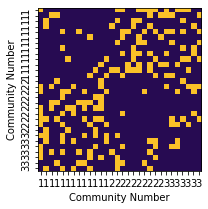

In [3]:
np.random.seed(63646)
n = 30
target_p = 0.2
p = np.min(np.roots([-1,2,-target_p]))
A = np.random.choice([0,1],p=[1-p,p],size=(n,n))
A = np.int32((A+A.T)>0)
Ci,Q = modularity(1-A,1)
order = np.argsort(Ci.flatten())
module = Ci.flatten()
plt.figure(figsize=(3,3))
plt.imshow(A[order,:][:,order],aspect='equal',cmap=plt.cm.inferno)
plt.clim(-0.2,1.2)
plt.xticks(np.arange(30),[f"{x:.0f}" for x in np.sort(module)])
plt.xlabel('Community Number')
plt.yticks(np.arange(30),[f"{x:.0f}" for x in np.sort(module)],rotation=90)
plt.ylabel('Community Number')
plt.show()